In [1]:
import csv
import os
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper,TURTLE,JSON
from pandas_ml import ConfusionMatrix
import pandas as pd
from sklearn import metrics

In [2]:
POIS_PATH = os.path.normpath('doremus_dbpedia_artists.csv')

with open(POIS_PATH, 'r') as input_fp:

    reader = csv.reader(input_fp, )
    # skip header
    reader.next()
    matches = []
    for row in reader:
        match = dict()
        match['doremus_uri'] = row[0]
        match['dbpedia_uri'] = row[1]
        match['score'] = row[2]
        matches.append(match)

In [3]:
len(matches)

10382

In [4]:
offset = 0
finished = False
true_matches = []

while finished is False:
    sparql = SPARQLWrapper("http://data.doremus.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.setQuery(
    """
    SELECT DISTINCT ?artist ?dbpedia
    WHERE {
      ?artist a ecrm:E21_Person ;
      owl:sameAs ?dbpedia .
      FILTER (strStarts(str(?dbpedia), 'http://dbpedia.org/resource/'))
    } limit 1000
    offset %d
    """ % offset)

    results = sparql.query().convert()
    if len(results['results']['bindings']) > 0:
        for result in results['results']['bindings']:
            match = dict()
            match['doremus_uri'] = result['artist']['value']
            match['dbpedia_uri'] = result['dbpedia']['value']
            true_matches.append(match)          
        offset += 1000
    else:
        finished = True

In [5]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['dbpedia_uri_x'])
    predict_label = list(join['dbpedia_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [6]:
import numpy as np
stat_list = []
for threshold in np.arange(0,1.0,0.1):
    values = list(stats(matches,true_matches,threshold))
    values.append(threshold)
    stat_list.append(values)
stat_list = np.array(stat_list)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pandas.lib is deprecated and will be removed in a future version.
You can access infer_dtype as pandas.api.types.infer_dtype
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is i

In [7]:
#accuracy,precision,recall,f1,intersection,predicted,true,threshold

In [8]:
import matplotlib.pyplot as plt

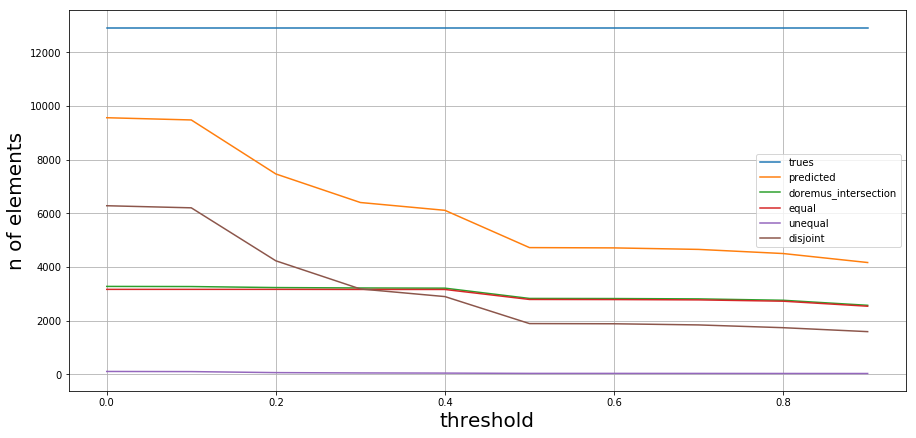

In [9]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,7])
plt.plot(stat_list[:,-1],stat_list[:,8])
plt.plot(stat_list[:,-1],stat_list[:,9])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['trues','predicted', 'doremus_intersection','equal','unequal','disjoint'])
#plt.title('number of documents per category',fontsize=20)
plt.show()

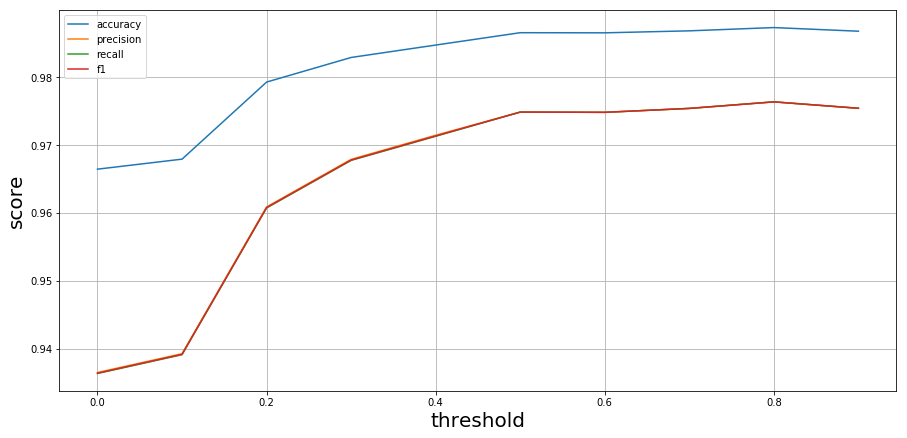

In [10]:
plt.figure(figsize=(15,7))
plt.plot(stat_list[:,-1],stat_list[:,0])
plt.plot(stat_list[:,-1],stat_list[:,1])
plt.plot(stat_list[:,-1],stat_list[:,2])
plt.plot(stat_list[:,-1],stat_list[:,3])
plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.legend(['accuracy', 'precision','recall','f1'])
plt.show()

## artists matched differently, choose the threshold

In [21]:
THRESHOLD = 0.0
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) > THRESHOLD]
true = pd.DataFrame(true_matches)
join = true.merge(predicted, on='doremus_uri')
types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
for col in types[types=='unicode'].index:
    join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
join = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
print(len(join))

a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri','score']].values.tolist()
for uri in a:
    pprint(uri)
a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri','score']]
a = a.rename_axis({"dbpedia_uri_y": "our_match", "dbpedia_uri_x": "your_match"}, axis="columns")
a = a.sort_values('score',ascending=False)
a.to_csv('different_artists_0.0.csv')

110
['http://dbpedia.org/resource/Peter_Cellensis',
 'http://dbpedia.org/resource/Peter_of_Blois',
 'http://data.doremus.org/artist/f1f68956-7ff0-3b37-b90f-ccdc4cc9fc3d',
 '0.17969840722']
['http://dbpedia.org/resource/Lars-Erik_Larsson',
 'http://dbpedia.org/resource/Lars',
 'http://data.doremus.org/artist/9003abb1-f722-3891-a40b-e5f8fad9ca92',
 '0.997']
['http://dbpedia.org/resource/Jack_Rabinovitch',
 'http://dbpedia.org/resource/Alexandre_Rabinovitch-Barakovsky',
 'http://data.doremus.org/artist/f15b7778-40a7-3be8-9b47-361e5a710f90',
 '0.17719840722']
['http://dbpedia.org/resource/James_Dillon_(officer)',
 'http://dbpedia.org/resource/James_Dillon_(composer)',
 'http://data.doremus.org/artist/0b9ff34c-e6ba-3aa6-825f-8c0599574665',
 '0.18769840722']
['http://dbpedia.org/resource/Nicol\xc3\xb2_Corradini_(composer)',
 'http://dbpedia.org/resource/Nicol\xc3\xb2_Corradini',
 'http://data.doremus.org/artist/fd0fda76-6a91-3eaf-8117-9de5b4a16125',
 '0.441']
['http://dbpedia.org/resource/\x

## artists that are not linked with dbpedia, choose the threshold

In [12]:
THRESHOLD = 0.9
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) > THRESHOLD]
#predicted = predicted[predicted['score'].astype(float) <= 1.1]
true = pd.DataFrame(true_matches)

predicted = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score').values.tolist()
print(len(predicted))
for uri in predicted:
        pprint(uri)

1594
['http://dbpedia.org/resource/Srul_Irving_Glick',
 'http://data.doremus.org/artist/991882a3-0408-3dea-935c-0bb3edf100b6',
 '0.90075']
['http://dbpedia.org/resource/Jean-Pierre_Ferland',
 'http://data.doremus.org/artist/f63c2e6b-2593-3e5f-93b1-1e93fc18c52e',
 '0.90075']
['http://dbpedia.org/resource/Larry_Sitsky',
 'http://data.doremus.org/artist/be2b4afe-962b-354a-8a36-5aa4e7ca0153',
 '0.90075']
['http://dbpedia.org/resource/Zsolt_Durk\xc3\xb3',
 'http://data.doremus.org/artist/9a095b50-b326-3256-97a2-03e358d44693',
 '0.90075']
['http://dbpedia.org/resource/Mario_Davidovsky',
 'http://data.doremus.org/artist/40c690d4-e49a-3def-96e2-14920f5def99',
 '0.90075']
['http://dbpedia.org/resource/Claudio_Prieto',
 'http://data.doremus.org/artist/346392cd-cc5b-3e6b-9194-0104ea2282db',
 '0.90075']
['http://dbpedia.org/resource/Norma_Beecroft',
 'http://data.doremus.org/artist/27dd28e8-0f57-3520-893c-90daa8836585',
 '0.90075']
['http://dbpedia.org/resource/Benjamin_Boretz',
 'http://data.dore

# wikidata

In [387]:
POIS_PATH = os.path.normpath('doremus_wikidata_artists.csv')

with open(POIS_PATH, 'r') as input_fp:

    reader = csv.reader(input_fp, )
    # skip header
    reader.next()
    matches = []
    for row in reader:
        match = dict()
        match['doremus_uri'] = row[0]
        match['wikidata_uri'] = row[1]
        match['score'] = row[5]
        matches.append(match)

In [388]:
len(matches)

2149

In [366]:
offset = 0
finished = False
true_matches = []

while finished is False:
    sparql = SPARQLWrapper("http://data.doremus.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.setQuery(
    """
    SELECT DISTINCT ?artist ?wikidata
    WHERE {
      ?artist a ecrm:E21_Person ;
      owl:sameAs ?wikidata .
      FILTER (strStarts(str(?wikidata), 'http://www.wikidata.org/entity/'))
    } limit 1000
    offset %d
    """ % offset)

    results = sparql.query().convert()
    if len(results['results']['bindings']) > 0:
        for result in results['results']['bindings']:
            match = dict()
            match['doremus_uri'] = result['artist']['value']
            match['wikidata_uri'] = result['wikidata']['value']
            true_matches.append(match)          
        offset += 1000
    else:
        finished = True

In [375]:
len(true_matches)

14631

In [ ]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['dbpedia_uri_x'])
    predict_label = list(join['dbpedia_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [379]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['wikidata_uri_x'])
    predict_label = list(join['wikidata_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['wikidata_uri_x'] == x['wikidata_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['wikidata_uri_x'] != x['wikidata_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [394]:
import numpy as np
stat_list = []
for threshold in np.arange(0,3.0,0.1):
    values = list(stats(matches,true_matches,threshold))
    values.append(threshold)
    stat_list.append(values)
stat_list = np.array(stat_list)

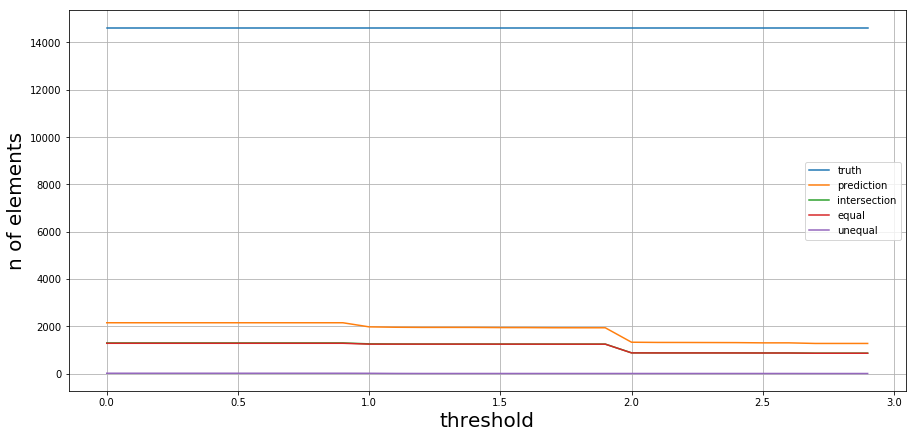

In [395]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,7])
plt.plot(stat_list[:,-1],stat_list[:,8])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','equal','unequal'])
plt.show()

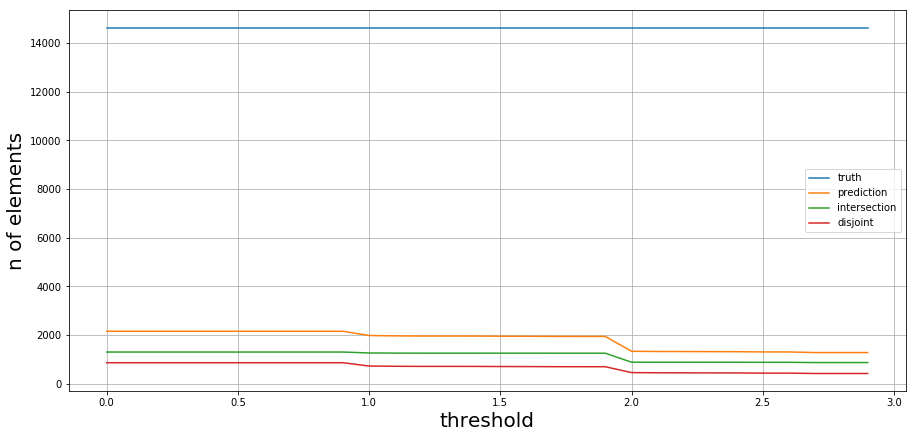

In [397]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,9])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','disjoint'])
plt.show()

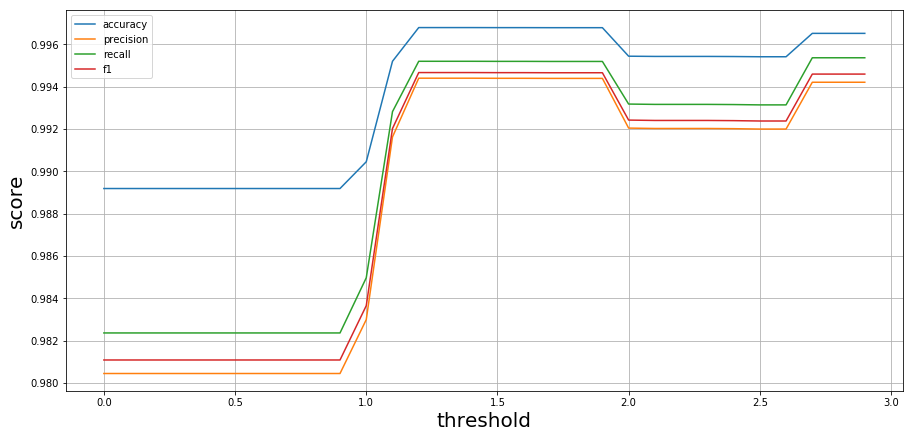

In [396]:
plt.figure(figsize=(15,7))
plt.plot(stat_list[:,-1],stat_list[:,0])
plt.plot(stat_list[:,-1],stat_list[:,1])
plt.plot(stat_list[:,-1],stat_list[:,2])
plt.plot(stat_list[:,-1],stat_list[:,3])
plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.legend(['accuracy', 'precision','recall','f1'])
plt.show()

In [406]:
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) >= 3.0]
true = pd.DataFrame(true_matches)

predicted = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score').values.tolist()
print(len(predicted))
for uri in predicted:
        pprint(uri)

413
['http://data.doremus.org/artist/009540ee-244b-3332-9c2f-2d6e09603677',
 '3.0',
 'http://www.wikidata.org/entity/Q5547245']
['http://data.doremus.org/artist/a27fc786-1c36-3a70-8e04-649237ed05b6',
 '3.0',
 'http://www.wikidata.org/entity/Q1231115']
['http://data.doremus.org/artist/a27b1b3b-d37d-3f04-a3a2-a62cccfca190',
 '3.0',
 'http://www.wikidata.org/entity/Q1687860']
['http://data.doremus.org/artist/a0d750ec-1d52-378a-8864-c1e499fa8667',
 '3.0',
 'http://www.wikidata.org/entity/Q966778']
['http://data.doremus.org/artist/a0c496af-0c8d-30ed-9858-3e495b4923ad',
 '3.0',
 'http://www.wikidata.org/entity/Q710733']
['http://data.doremus.org/artist/a06fb3a5-2ee7-39fd-93c8-d3cc757cde77',
 '3.0',
 'http://www.wikidata.org/entity/Q46096']
['http://data.doremus.org/artist/9dd438f3-fdc9-355b-893e-e7bb9ab147d9',
 '3.0',
 'http://www.wikidata.org/entity/Q1290316']
['http://data.doremus.org/artist/9dbaadc5-e795-3306-982c-8b2bd5187340',
 '3.0',
 'http://www.wikidata.org/entity/Q48173']
['http://d

Here we can find one more negative match, http://data.doremus.org/artist/9f31efcb-014c-36ee-bea8-ad5fe3953097 , and in this case we are wrong. This means that after the threshold of 3.8 we start having some problems.  